# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os

#for data preprocessing
import nltk 
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#for bow
from sklearn.feature_extraction.text import CountVectorizer

#for tfid
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#for validation
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.classification import accuracy_score, log_loss

/Users/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#Import data
con=sqlite3.connect('database.sqlite')
data=pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """,con)
print("data shape",data.shape)
data.head(2)


data shape (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [3]:
#Select data whose score >3 considered positve==1 AND score<3 considered as negative=0
def par(x):
    if x<3:
        return 0
    return 1
data1=data['Score']
data2=data1.map(par)
data['Score']=data2
data.shape


(525814, 10)

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
data.isnull().sum() #Their are no any NAN

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sort_data=data.sort_values(
    'ProductId',
    axis=0,
    ascending=True,
    inplace=False,
    kind='quicksort',
    na_position='last',
    ignore_index=False,
)

In [6]:
sort_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [7]:
#Deduplication of entries
dataframe=sort_data.drop_duplicates(subset={'UserId','ProfileName','Text' })
dataframe.shape

(363899, 10)

In [8]:
#Checking to see how much % of data still remains
(dataframe['Id'].size*1.0)/(data['Id'].size*1.0)*100

69.20679175525947

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
dataframe=dataframe[dataframe.HelpfulnessNumerator<=dataframe.HelpfulnessDenominator]

In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(dataframe.shape)


(363897, 10)


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
# printing some random reviews
sent_0 = dataframe['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = dataframe['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = dataframe['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = dataframe['Text'].values[4900]
print(sent_4900)
print("="*50)



this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [13]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [14]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [17]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [18]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [19]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [20]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(dataframe['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 363897/363897 [03:12<00:00, 1888.64it/s]


In [46]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [21]:
dataframe['preprocessed_reviews']=preprocessed_reviews
dataframe.shape

(363897, 11)

In [22]:
print("No of data points: ",dataframe.shape[0])
print("no of features:",dataframe.shape[1])
print("features:",dataframe.columns.values)



No of data points:  363897
no of features: 11
features: ['Id' 'ProductId' 'UserId' 'ProfileName' 'HelpfulnessNumerator'
 'HelpfulnessDenominator' 'Score' 'Time' 'Summary' 'Text'
 'preprocessed_reviews']


<h3> Test, Train and Cross Validation Split</h3>

In [23]:
## sorting data as per time based
df=dataframe.sort_values('Time',
    axis=0,
    ascending=True,
    inplace=False,
    kind='quicksort',
    na_position='last',
    ignore_index=False,
)
df=df.reset_index()
df.head(5)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_reviews
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...


In [24]:
from sklearn.model_selection import train_test_split
import math

In [25]:
dataframe['Score'].value_counts()

1    306814
0     57083
Name: Score, dtype: int64

In [26]:
X=np.array(dataframe['preprocessed_reviews'])
Y=np.array(dataframe['Score'])
print(type(X))
print(type(Y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [27]:
X_train1, X_test = np.split (X, [int(0.7*len(X))])
X_train, X_cv = np.split(X_train1, [int(0.7*len(X_train1))])
Y_train1, y_test = np.split (Y, [int(0.7*len(Y))])
y_train, y_cv = np.split(Y_train1, [int(0.7*len(Y_train1))])
print ('X_train shape = ',X_train.shape)
print ('X_test shape = ',X_test.shape)
print ('X_cv shape = ',X_cv.shape)
print ('y_train shape = ',y_train.shape)
print ('y_test shape = ',y_test.shape)
print ('y_cv shape = ',y_cv.shape)

X_train shape =  (178308,)
X_test shape =  (109170,)
X_cv shape =  (76419,)
y_train shape =  (178308,)
y_test shape =  (109170,)
y_cv shape =  (76419,)


<h2>Prediction using a 'Random' Model</h2>

# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [30]:
#Applying Bag Of Words
count_vect = CountVectorizer()
X_train_bow = count_vect.fit_transform(X_train)
X_test_bow = count_vect.transform(X_test)
X_cv_bow = count_vect.transform(X_cv)

In [31]:
print("(number of data points * number of features) in train data = ", X_train_bow.shape)
print("(number of data points * number of features) in test data = ", X_test_bow.shape)
print("(number of data points * number of features) in cross validation data =", X_cv_bow.shape)

(number of data points * number of features) in train data =  (178308, 80070)
(number of data points * number of features) in test data =  (109170, 80070)
(number of data points * number of features) in cross validation data = (76419, 80070)


In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from tqdm import tqdm

for alpha = 1e-05
Log Loss : 0.2824064784304123
for alpha = 0.0001
Log Loss : 0.27726708312695647
for alpha = 0.001
Log Loss : 0.27013319192454555
for alpha = 0.1
Log Loss : 0.2548185712652569
for alpha = 1
Log Loss : 0.26370393693911537
for alpha = 10
Log Loss : 0.3941452356802441
for alpha = 100
Log Loss : 0.42990582026693047
for alpha = 1000
Log Loss : 0.42990805824021155


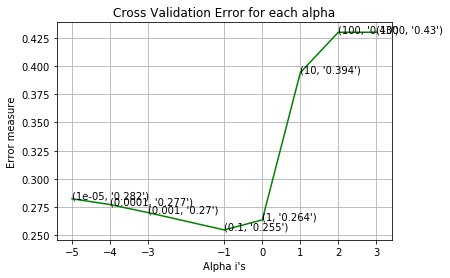

In [65]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/naive-bayes-algorithm-1/
# -----------------------

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(X_train_bow, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_bow,y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv_bow)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()



In [70]:
best_alpha = np.argmin(cv_log_error_array)
clf_1 = MultinomialNB(alpha=alpha[best_alpha])
clf_1.fit(X_train_bow, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_bow, y_train)
predict_y = sig_clf.predict_proba(X_train_bow)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv_bow)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test_bow)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))

For values of best alpha =  0.1 The train log loss is: 0.2066384198242968
For values of best alpha =  0.1 The cross validation log loss is: 0.2548185712652569
For values of best alpha =  0.1 The test log loss is: 0.2696607026566235


In [50]:
opt_model=MultinomialNB(alpha=best_alpha)
opt_model.fit(X_train_bow,y_train)
prediction= opt_model.predict(X_test_bow)

In [71]:
training_accuracy = clf_1.score(X_train_bow, y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.9263185050586625
Train Error:  0.07368149494133747
Test Accuracy:  0.8954108271503161
Test Error:  0.10458917284968394
_____________________________________________________________________________________________________


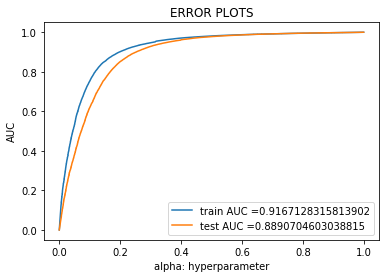

In [55]:
#ploting AUC CURVE
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, opt_model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, opt_model.predict_proba(X_test_bow)[:,1])
AUC1=str(auc(test_fpr, test_tpr))

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


In [56]:
training_accuracy = opt_model.score(X_train_bow, y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(y_test, prediction)
test_error = 1 - test_accuracy


print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)

_____________________________________________________________________________________________________
Training Accuracy:  0.9124212037597864
Train Error:  0.08757879624021359
Test Accuracy:  0.8954108271503161
Test Error:  0.10458917284968394
_____________________________________________________________________________________________________


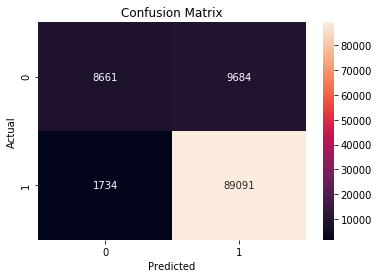

_____________________________________________________________________________________________________


In [57]:


import seaborn as sb
conf_matrix = confusion_matrix(y_test, opt_model.predict(X_test_bow))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)



In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))
    

              precision    recall  f1-score   support

           0       0.83      0.47      0.60     18345
           1       0.90      0.98      0.94     90825

    accuracy                           0.90    109170
   macro avg       0.87      0.73      0.77    109170
weighted avg       0.89      0.90      0.88    109170



In [72]:
tn, fp, fn, tp = confusion_matrix(y_test,  prediction).ravel()
p = tp+fn #p = total number of actual postives
n = fp+tn #p = total number of actual negatives
TPR = tp/p ; TNR = tn/n ; FPR = fp/n ; FNR = fn/p
print("\nThe True Positives Rate is : {}".format(TPR))
print("The True Negatives Rate is : {}".format(TNR))
print("The False Positives Rate is : {}".format(FPR))
print("The False Negatives Rate is : {}".format(FNR))


The True Positives Rate is : 0.9809083402146986
The True Negatives Rate is : 0.47211774325429273
The False Positives Rate is : 0.5278822567457073
The False Negatives Rate is : 0.019091659785301404


### [5.1.1] Top 50 important features of positive class from<font color='red'> SET 1</font>

In [76]:
'''Top 10 positive features using feature_log_prob_ function'''
pos_class_prob_sorted = mnb.feature_log_prob_[1].argsort()
print (np.take(count_vect.get_feature_names(), pos_class_prob_sorted[-50:]))

['water' 'bought' 'add' 'bag' 'made' 'day' 'mix' 'could' 'store'
 'delicious' 'dog' 'chocolate' 'first' 'sugar' 'free' 'found' 'used' 'try'
 'eat' 'better' 'even' 'tried' 'buy' 'well' 'price' 'little' 'make' 'much'
 'coffee' 'find' 'also' 'time' 'really' 'best' 'amazon' 'use' 'no' 'food'
 'get' 'would' 'flavor' 'love' 'product' 'taste' 'one' 'tea' 'great'
 'good' 'like' 'not']


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [75]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
'''Top 10 negitive features using feature_log_prob_ function'''
pos_class_prob_sorted = mnb.feature_log_prob_[0].argsort()
print (np.take(count_vect.get_feature_names(), pos_class_prob_sorted[-50:]))

['way' 'thought' 'chocolate' 'well' 'little' 'sugar' 'price' 'love' 'two'
 'never' 'ordered' 'used' 'order' 'great' 'know' 'got' 'use' 'make' 'bag'
 'try' 'dog' 'bad' 'also' 'eat' 'made' 'better' 'first' 'coffee' 'tried'
 'time' 'box' 'could' 'bought' 'really' 'much' 'buy' 'amazon' 'even' 'get'
 'food' 'flavor' 'tea' 'good' 'no' 'one' 'taste' 'would' 'product' 'like'
 'not']


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [29]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
# Please write all the code with proper documentation
vectorizertf = TfidfVectorizer(ngram_range=(1,2), min_df=5)

X_train_tf=vectorizertf.fit_transform(X_train)
X_test_tf=vectorizertf.transform(X_test)
X_cv_tf=vectorizertf.transform(X_cv)
print(X_train_tf.shape)
print(X_test_tf.shape)
print(X_cv_tf.shape)

(178308, 214472)
(109170, 214472)
(76419, 214472)


In [31]:
from tqdm import tqdm

In [34]:
# Finding best alpha hyperparameter between 10^-5 to 10^5
train_auc = []
cv_auc = []
alphas = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
for i in (alphas):
    clf = MultinomialNB(alpha=i,class_prior=[0.5,0.5])
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_tf, y_train)
    train_pred =  sig_clf.predict_proba(X_train_tf)[:,1]
    cv_pred =  sig_clf.predict_proba(X_cv_tf)[:,1]
    train_auc.append(roc_auc_score(y_train, train_pred))
    cv_auc.append(roc_auc_score(y_cv, cv_pred))



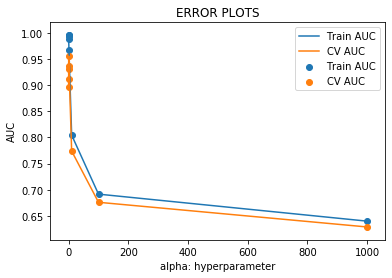

In [35]:
plt.plot(alphas, train_auc, label='Train AUC')
plt.scatter(alphas, train_auc, label='Train AUC')
plt.plot(alphas, cv_auc, label='CV AUC')
plt.scatter(alphas, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

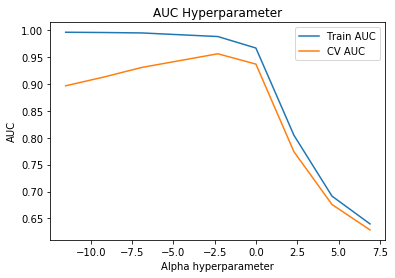

In [36]:
alpha_hyper = []

for i in (alphas):
    alpha_hyper.append(np.log(i))
fig = plt.figure()
axis = plt.subplot(111)
axis.plot(alpha_hyper, train_auc, label='Train AUC')
axis.plot(alpha_hyper, cv_auc, label='CV AUC')
plt.title("AUC Hyperparameter")
plt.xlabel("Alpha hyperparameter")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [39]:
#function for cross validation score
cv_score=[]
kn=[0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
for i in (kn):
    my_cv = TimeSeriesSplit(n_splits=10).split(X_train_tf)
    mnb = MultinomialNB(alpha=i, class_prior=[0.5,0.5])
    sig_clf = CalibratedClassifierCV(mnb, method="sigmoid")
    score=cross_val_score(sig_clf,X_train_tf,y_train,cv=my_cv ,scoring='accuracy')
    cv_score.append(score.mean())

In [40]:
MSE=[ 1- x for x in cv_score]
optimal_al=kn[MSE.index(min(MSE))]
print('optimal k:',optimal_al)
print('missclassification error:',np.round(MSE,3))

optimal k: 0.1
missclassification error: [0.116 0.108 0.097 0.082 0.105 0.144 0.153 0.151]


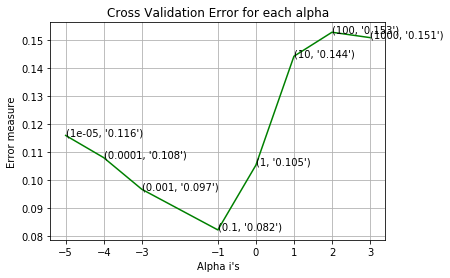

In [48]:
fig, ax = plt.subplots()
ax.plot(np.log10(alphas), MSE,c='g')
for i, txt in enumerate(np.round(MSE,3)):
     ax.annotate((alphas[i],str(txt)), (np.log10(alphas[i]),MSE[i]))
plt.grid()
plt.xticks(np.log10(alphas))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [58]:
opt_model_1=MultinomialNB(alpha=optimal_al, class_prior=[0.5,0.5])
opt_model_1.fit(X_train_tf,y_train)
prediction= opt_model_1.predict(X_test_tf)

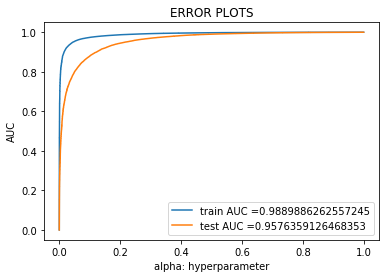

In [59]:
#ploting AUC CURVE
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, opt_model_1.predict_proba(X_train_tf)[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, opt_model_1.predict_proba(X_test_tf)[:,1])
AUC2=str(auc(test_fpr, test_tpr))

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [61]:


training_accuracy = opt_model_1.score(X_train_tf, y_train)
training_error = 1 - training_accuracy
test_accuracy = accuracy_score(y_test, prediction)
test_error = 1 - test_accuracy
print("_" * 101)
print("Training Accuracy: ", training_accuracy)
print("Train Error: ", training_error)
print("Test Accuracy: ", test_accuracy)
print("Test Error: ", test_error)
print("_" * 101)



_____________________________________________________________________________________________________
Training Accuracy:  0.9353478251116046
Train Error:  0.06465217488839536
Test Accuracy:  0.9031785288998809
Test Error:  0.09682147110011907
_____________________________________________________________________________________________________


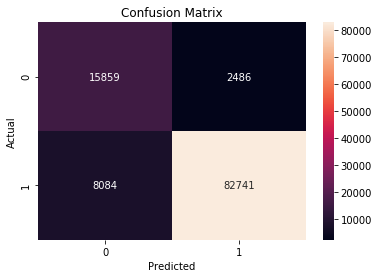

_____________________________________________________________________________________________________


In [62]:
import seaborn as sb
conf_matrix = confusion_matrix(y_test, opt_model_1.predict(X_test_tf))
class_label = [0, 1]
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.66      0.86      0.75     18345
           1       0.97      0.91      0.94     90825

    accuracy                           0.90    109170
   macro avg       0.82      0.89      0.85    109170
weighted avg       0.92      0.90      0.91    109170



In [74]:
tn, fp, fn, tp = confusion_matrix(y_test,  prediction).ravel()
p = tp+fn #p = total number of actual postives
n = fp+tn #p = total number of actual negatives
TPR = tp/p ; TNR = tn/n ; FPR = fp/n ; FNR = fn/p
print("\nThe True Positives Rate is : {}".format(TPR))
print("The True Negatives Rate is : {}".format(TNR))
print("The False Positives Rate is : {}".format(FPR))
print("The False Negatives Rate is : {}".format(FNR))


The True Positives Rate is : 0.9109936691439582
The True Negatives Rate is : 0.8644862360316162
The False Positives Rate is : 0.13551376396838374
The False Negatives Rate is : 0.08900633085604184


### [5.2.1] Top 50 important features of positive class from<font color='red'> SET 2</font>

In [72]:
# Please write all the code with proper documentation
mnb_1 = MultinomialNB(alpha=optimal_al, class_prior = [0.5, 0.5])
mnb_1.fit(X_train_tf, y_train)


'''Top 10 positive features using feature_log_prob_ function'''
pos_class_prob_sorted = mnb_1.feature_log_prob_[1].argsort()
print (np.take(vectorizertf.get_feature_names(), pos_class_prob_sorted[-50:]))


['easy' 'day' 'recommend' 'sweet' 'bought' 'mix' 'loves' 'favorite'
 'order' 'store' 'sugar' 'try' 'found' 'even' 'used' 'dog' 'free'
 'chocolate' 'delicious' 'eat' 'better' 'tried' 'well' 'also' 'make' 'buy'
 'little' 'much' 'no' 'time' 'really' 'price' 'food' 'get' 'find' 'use'
 'amazon' 'would' 'best' 'coffee' 'flavor' 'taste' 'one' 'product' 'love'
 'like' 'good' 'tea' 'great' 'not']


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [73]:
# Please write all the code with proper documentation
pos_class_prob_sorted = mnb_1.feature_log_prob_[0].argsort()
print (np.take(vectorizertf.get_feature_names(), pos_class_prob_sorted[-50:]))

['two' 'item' 'price' 'way' 'tasted' 'tastes' 'away' 'know' 'try'
 'not buy' 'chocolate' 'first' 'never' 'received' 'bag' 'better' 'got'
 'thought' 'order' 'would not' 'made' 'eat' 'time' 'dog' 'tried' 'ordered'
 'really' 'money' 'disappointed' 'coffee' 'could' 'much' 'bad' 'amazon'
 'bought' 'box' 'get' 'food' 'even' 'buy' 'good' 'flavor' 'tea' 'no' 'one'
 'taste' 'would' 'product' 'like' 'not']


# [6] Conclusions